<a href="https://colab.research.google.com/github/FinnSkers/Cotton_Plant_Disease_checker/blob/main/CPD_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [33]:
path="/content/drive/MyDrive/archive/31-05-23"
IMAGESIZE=256
BATCHSIZE=15
EPOCHS=50
CHANNELS=3

In [34]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    path,
    shuffle=True,
    image_size=(IMAGESIZE,IMAGESIZE),
    batch_size=BATCHSIZE
)

Found 240 files belonging to 6 classes.


In [35]:
class_names=dataset.class_names
class_names
print(class_names)
print(len(class_names))

['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']
6


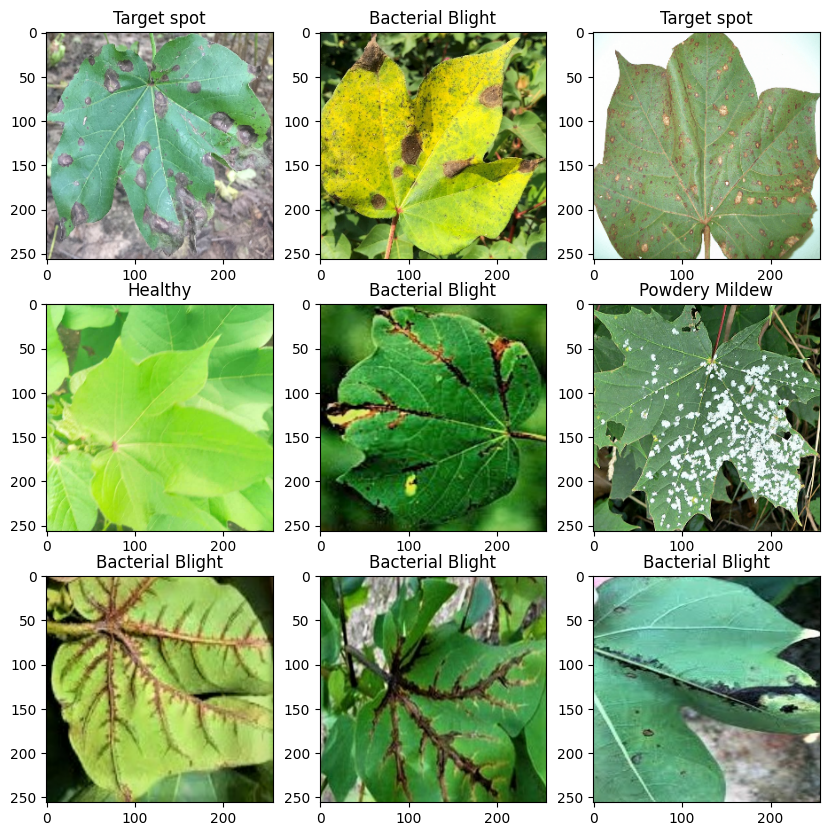

In [36]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])

In [37]:
def get_dataset_part(ds, t_s=.8, v_s=.1, test_s=.1, shuffle=True, shuffle_size=10000):
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size, seed=12)
  t_size=int(ds_size*t_s)
  v_size=int(ds_size*v_s)
  train_ds=ds.take(t_size)
  val_ds=ds.skip(t_size).take(v_size)
  test_ds=ds.skip(t_size).skip(v_size)

  return train_ds, val_ds, test_ds

In [38]:
train_ds, val_ds, test_ds=get_dataset_part(dataset)

In [39]:
print(f'''
Train_Dataset={len(train_ds)}
Validation_Dataset={len(val_ds)}
Test_Dataset={len(test_ds)}''')


Train_Dataset=12
Validation_Dataset=1
Test_Dataset=3


In [40]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGESIZE,IMAGESIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [42]:
data_aug=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)])

In [43]:
input_shape=(IMAGESIZE,IMAGESIZE,CHANNELS)
n_classes= len(class_names)
model=models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32,(3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.Dense(6,activation='softmax')
])
model.build(input_shape=(20,256,256,3))

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (20, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (20, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (20, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (20, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (20, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (20, 62, 62, 64)         0         
 2D)                                                  

In [45]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [46]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCHSIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
12/12 [==============================] - 9s 156ms/step - loss: 1.8079 - accuracy: 0.1722 - val_loss: 1.7916 - val_accuracy: 0.0000e+00
Epoch 2/50
12/12 [==============================] - 0s 33ms/step - loss: 1.7925 - accuracy: 0.1722 - val_loss: 1.7834 - val_accuracy: 0.0000e+00
Epoch 3/50
12/12 [==============================] - 0s 33ms/step - loss: 1.7889 - accuracy: 0.2222 - val_loss: 1.7834 - val_accuracy: 0.2667
Epoch 4/50
12/12 [==============================] - 0s 33ms/step - loss: 1.7756 - accuracy: 0.2333 - val_loss: 1.6181 - val_accuracy: 0.2667
Epoch 5/50
12/12 [==============================] - 0s 33ms/step - loss: 1.7669 - accuracy: 0.1833 - val_loss: 1.8119 - val_accuracy: 0.0000e+00
Epoch 6/50
12/12 [==============================] - 0s 33ms/step - loss: 1.7248 - accuracy: 0.2500 - val_loss: 1.5427 - val_accuracy: 0.2667
Epoch 7/50
12/12 [==============================] - 0s 34ms/step - loss: 1.5368 - accuracy: 0.3444 - val_loss: 1.2942 - val_accuracy: 0.5333


In [47]:
scores=model.evaluate(test_ds)

3/3 [==============================] - 1s 13ms/step - loss: 0.4610 - accuracy: 0.8889


In [48]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

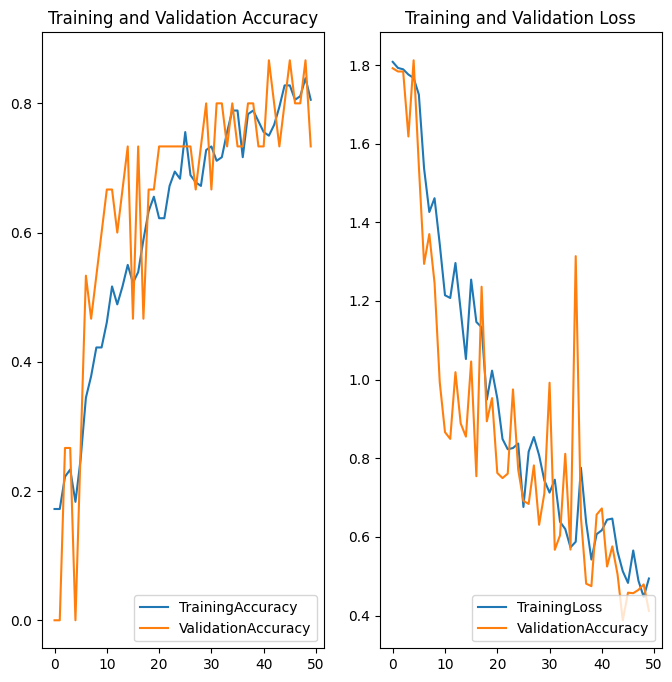

In [49]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='TrainingAccuracy')
plt.plot(range(EPOCHS),val_acc,label='ValidationAccuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='TrainingLoss')
plt.plot(range(EPOCHS),val_loss,label='ValidationAccuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [50]:
model.save('/content/drive/MyDrive/archive/model_1_00.h5')

first image to predict
actual label: Powdery Mildew
1/1 [==============================] - 0s 27ms/step
predicted label: Powdery Mildew


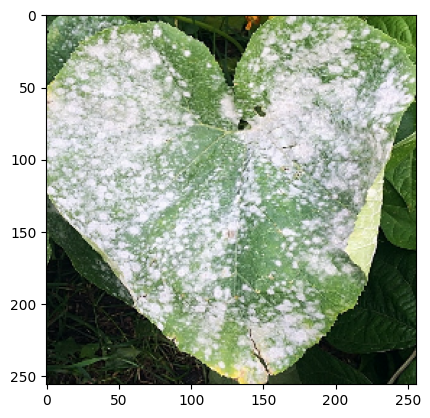

In [57]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


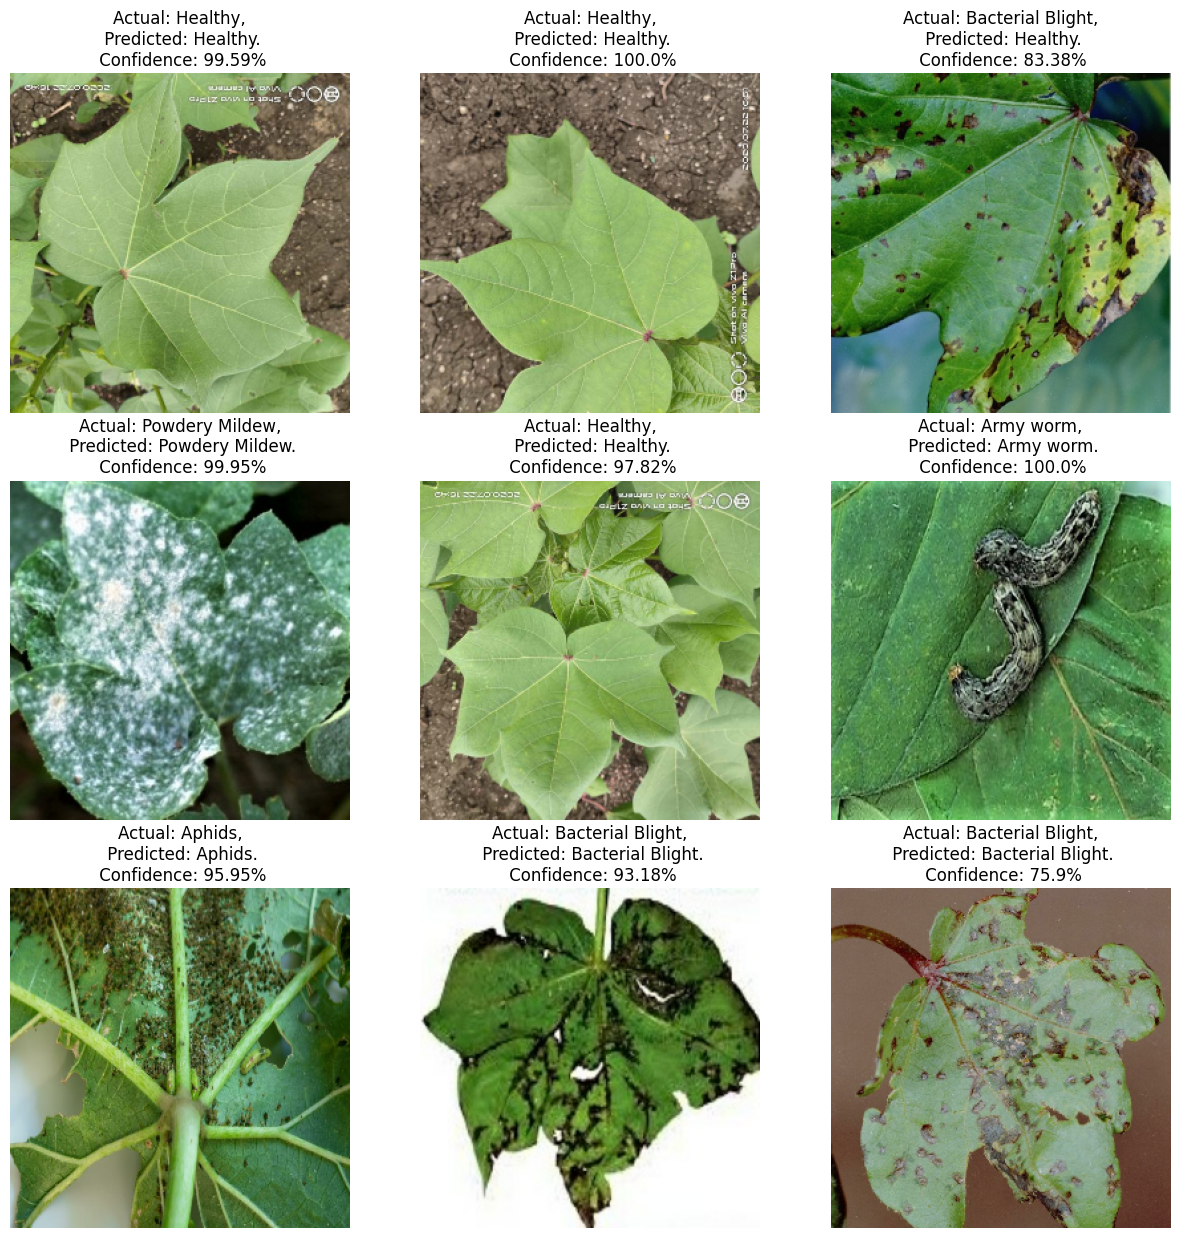

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")